In [1]:
# first a better implementation of creating polygons from masks



In [141]:
import PIL.Image
import skimage.measure
import imgviz
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev
from ultralytics import YOLO
# dont make the plt use agg backend
%matplotlib inline


In [142]:
# create a yolo model and run it on test.jpg
model = YOLO('labelme-master/yolov8x-seg.pt')
model.fuse()


YOLOv8x-seg summary (fused): 295 layers, 71797696 parameters, 0 gradients, 344.1 GFLOPs


(1497, 2250)


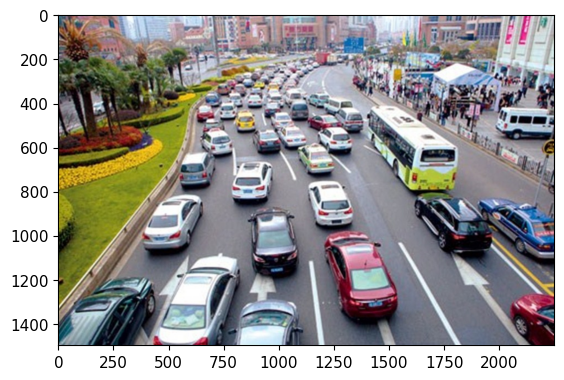

In [153]:
# img = PIL.Image.open('mai_02.jpg')
img = cv2.imread('mai_02.jpg')
img = cv2.imread('labelme-master/test_img_1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_size = img.shape[:2]
print(img_size)
# resize to 640x640
img_resized = cv2.resize(img, (640, 640))
# show the image
plt.imshow(img)

plt.show()

In [154]:
results = model(img_resized , conf = 0.5 , iou=  0.5 , imgsz = 640 )
results = results[0]

print(results.masks.shape)

masks = results.masks.cpu().numpy().masks 
# convert masks to numpy array 



0: 640x640 10 cars, 1 bus, 55.0ms
Speed: 0.0ms preprocess, 55.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


torch.Size([11, 640, 640])


In [155]:
print(type(masks))
image = img.copy()
print(masks.shape)
masks = masks > 0.0
print(masks.shape[1:])



<class 'numpy.ndarray'>
(11, 640, 640)
(640, 640)


In [157]:

print(masks.shape[1:])
print(img_size)


(640, 640)
(1497, 2250)


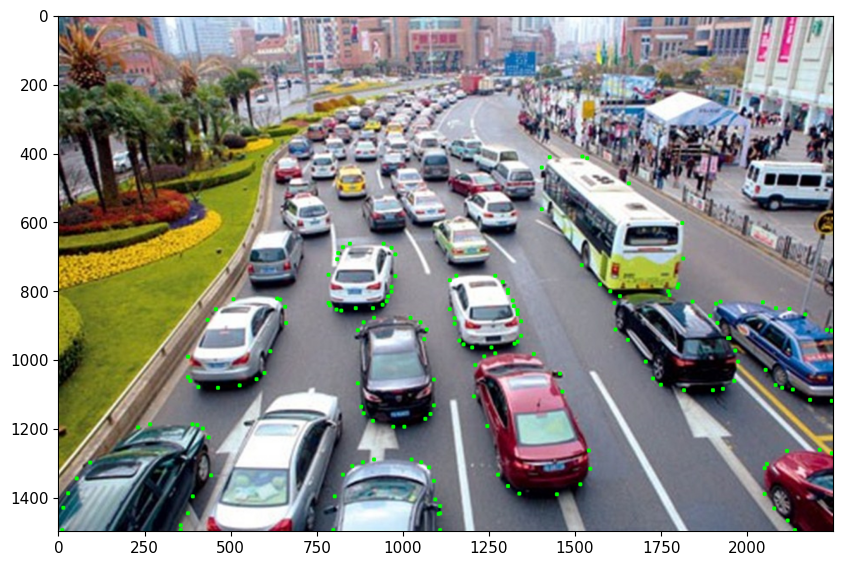

In [158]:

image = img.copy()
def get_contour_length(contour):
    contour_start = contour
    contour_end = np.r_[contour[1:], contour[0:1]]
    return np.linalg.norm(contour_end - contour_start, axis=1).sum()


for i, mask in enumerate(masks):

    contours = skimage.measure.find_contours(mask)
    contour = max(contours, key=get_contour_length)
    coords = skimage.measure.approximate_polygon(
        coords=contour,
        tolerance=np.ptp(contour, axis=0).max() / 100,
    )
    
    # we need to convert coords from resutls.orig_shape to img_size
    coords = coords * img_size / masks.shape[1:]
    # print(coords)
    
    for coord in coords:
        
        # print(coord)
        
        cv2.circle(image, (int(coord[1]), int(coord[0])), 1, (0, 255, 0), 10)
# save the image with the masks as jpg
plt.figure(figsize=(10,10))
plt.imshow(image)